In [1]:
#this notebook was run locally on the fastai.v1 -> the new online v2 version has sometimes different syntax
from fastai.vision import *
import os
import numpy as np

<h2>Overview: Training a multi-class model and building a "Tinder for Earth Scientists"</h2>
In step 1-5 the model is trained with the fast.ai vision library on training data set ~30 images/class. This is quite little, but we ran the training locally via cuda. At step 6. the trained model is used to make predictions and output percentage values for each class (the higher the percentage, the more certain the algorithm). After that we began building the whole recommendation system on top - however, the NASA datasets are quite diverse & a little overwhelming so we need more time to master and label them thoroughly. But that is exactly why we want to build a "Tinder for Earth Scientists" so they have the datasets clearly laid out in the future.

In [2]:
maindir = Path('C:\\Users\\Alex Waldherr\\Documents\\Space Apps Challenge')
maindir_data = maindir
os.listdir(maindir_data)

['Agriculture',
 'Clouds',
 'Fire',
 'Floods',
 'Glaciers',
 'Hurricane',
 'Infrastructure',
 'Ocean',
 'Sealife',
 'Vegetation']

<h2>1. Check if all image-formats are correct</h2>
Does change the quality of each image!
For each class our small dataset contains approximately 30 satellite images from the Earth Observatory Website :)

In [3]:
for folder in os.listdir(maindir_data):
    print(folder)
    verify_images(maindir_data/folder, delete=True, max_size=1000)

Agriculture


Clouds


Fire


Floods


Glaciers


Hurricane


Infrastructure


Ocean


Sealife


Vegetation


<h2>2. View data</h2>
Check if the images definitely show the correct classes. The ImageDataBunch splits all provided images into a 20% validation and 80% training data set.

In [4]:
np.random.seed(42)
data = ImageDataBunch.from_folder(maindir_data, train=".", valid_pct=0.2, size=(224, 224), num_workers=4, bs=64).normalize(imagenet_stats)
#size=(224, 490)

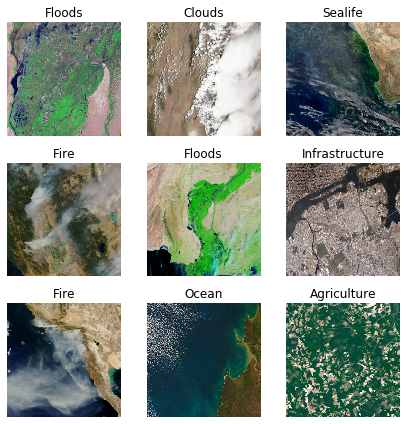

In [6]:
data.classes
data.show_batch(rows=3, figsize=(6, 6))

In [7]:
#which classes? num classes? num training data? num validation data?
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Agriculture',
  'Clouds',
  'Fire',
  'Floods',
  'Glaciers',
  'Hurricane',
  'Infrastructure',
  'Ocean',
  'Sealife',
  'Vegetation'],
 10,
 231,
 57)

<h2>3. Initial Training</h2>

In [8]:
from fastai.metrics import error_rate
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [9]:
defaults.device = torch.device("cuda")
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,3.683560,2.919858,0.789474,01:04
1,2.687204,1.654669,0.456140,00:56
2,1.963493,1.181273,0.280702,00:57
3,1.538301,0.957730,0.263158,00:56


In [8]:
learn.unfreeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [11]:
learn.fit_one_cycle(4, max_lr=slice(1e-4, 5e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.401611,0.893849,0.228070,00:55
1,0.402724,0.877786,0.228070,00:58
2,0.371967,0.903096,0.228070,00:56
3,0.353463,0.918942,0.210526,00:56


In [12]:
learn.save('spaceapppred-stage-1')

In [13]:
learn.export("export.pkl")

<h2>4. Interpretation</h2>

In [14]:
interpretation = ClassificationInterpretation.from_learner(learn)

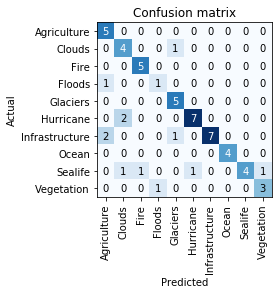

In [15]:
interpretation.plot_confusion_matrix()

Most mistakes: 
hurricanes -> predicted as clouds (actually somehow true;
infrastructure -> predicted as agriculture (need more training probably)

<h2>5. Output </h2>
This is just to check the validation outputs while training. Skip to "6. Predict images".

In [27]:
classes = learn.data.classes
preds, gt = learn.get_preds()
preds = preds.tolist()

In [ ]:
for runs in preds:
    confidences = {}
    i = 0
    for class_run in runs:
        append_dict = {classes[i]: class_run}
        confidences.update(append_dict)
        i += 1
    #print(confidences)

<h2>6. Predict Images to find your datasets</h2>

In [67]:
data_from_prediction = learn.predict(open_image("C:\\Users\\Alex Waldherr\\Documents\\Space Apps Challenge\\MODIS_Weather.jpg"))
data_from_prediction[0]

Category Hurricane

In [68]:
classes = learn.data.classes
confidences = {}
i = 0
for class_run in data_from_prediction[2]:
        append_dict = {classes[i]: float(class_run) * 100}
        confidences.update(append_dict)
        i += 1
print(confidences)

{'Agriculture': 0.31839674338698387, 'Clouds': 32.483816146850586, 'Fire': 2.331078238785267, 'Floods': 0.058004428865388036, 'Glaciers': 3.182785212993622, 'Hurricane': 57.83681869506836, 'Infrastructure': 0.6491853389889002, 'Ocean': 0.11113074142485857, 'Sealife': 2.8922518715262413, 'Vegetation': 0.13653895584866405}


<h2>7. Find datasets with similar information</h2>

STILL IN THE BUILDING PHASE! THE NASA DATASET FORMATS ARE MORE COMPLICATED THAN EASILY TO BE INTEGRATED DURING THE WEEKEND!
We want to established a relational array with weighted values for the important characteristics of: 
<ol>
    <li>spatial resolution (numerical values)</li>
    <li>temporal resolution/orbits: 
        <ul>
            <li>polar (1-16 days)</li>
            <li>non-polar (daily to monthly)</li>
            <li>geostationary (30s - some minutes)</li>
        </ul>
    <li>wavelength:
        <ul>
            <li>microwave</li>
            <li>infrared</li>
            <li>visible (this is compatible with our training dataset therefore we go only for this but with numerical value in nm here)</li>
            <li>UV</li>
        </ul>
    <li>hardware device/sensor:
        <ul>
            <li>radiometer</li>
            <li>spectrometer (this is compatible with our training dataset)</li> 
            <li>radar</li>
            <li>altimeter</li>
            <li>scatterometer</li>
            <li>laser</li>
        </ul>
    <li>data type: 
        images (time-series, etc. not added during this hackathon)</li>
</ol>

Now researchers can click/enter values down below for all characteristics important to them. Those values are weighted and compared to the assessed datasets in the database. With the help of the ML-image recognition (filter the scope of datasets' topics) the best scored datasets (aka best correlation between researcher's requirements and dataset characteristics) are then printed out with links to the sources on the screen. 

Also recommendation for data processing (aka which AI-algorithms work best with this type of satellite data? which data processing have other researchers already used on this dataset?) are given.

**Datasets we assessed were from LAADS:**
<ul>
    <li> ENVISAT (Land and Ocean, visible wavelengths) </li>
    <li> MODIS (Land and Weather, visible wavelengths) </li>
</ul>

Good resources:
https://earthdata.nasa.gov/ (tutorials)

https://search.earthdata.nasa.gov/search (still need to understand this properly)

https://www.youtube.com/watch?v=vJzSYk1Ip6I (helps so much in navigating the first time)

https://wiki.earthdata.nasa.gov/display/GIBS/GIBS+Available+Imagery+Products

https://github.com/chrieke/awesome-satellite-imagery-datasets (not all satellite parameters given)

In [ ]:
#dict_datasets was built in the following form:
#{'Dataset1': ['radiometric resolution (null if not found)', 
#              'spatial (in m)', 
#              'temporal (as orbit)', 
#              'wavelength (as nm)', 
#              'sensor', 
#              'data type (as file extension)', 
#              'AI values',
#              'relevant sources']}

#I am not really into backend programming, but it would be cool to 1. establish a real database (not a dictionary), 2. get more familiar with the NASA datasets and -types, 3. add a NLP-layer to filter out processing suggestions from previous papers.

dict_datasets: {
    'Land Dataset - Envisat MERIS Land': ['260', 
                 'polar', 
                 750, #390-1040 nm but 700-900 good for vegetation & clouds
                 'spectrometer', 
                 '.jpg',
                 {'Agriculture': 38.01327347755432, 'Clouds': 0.05788917769677937, 'Fire': 0.19440411124378443, 'Floods': 0.48990598879754543, 'Glaciers': 0.01014821245917119, 'Hurricane': 0.026400445494800806, 'Infrastructure': 53.89089584350586, 'Ocean': 0.08804110111668706, 'Sealife': 0.23023891262710094, 'Vegetation': 6.998801976442337},
                'http://envisat.esa.int/handbooks/meris/CNTR4-2-8.html']
    'Ocean Dataset - Envisat MERIS Ocean': ['1040', 
                 'polar', 
                 750, #390-1040 nm but 700-900 good for vegetation & clouds
                 'spectrometer', 
                 '.jpg',
                 {'Agriculture': 0.5313796456903219, 'Clouds': 0.0050597358494997025, 'Fire': 0.6777452304959297, 'Floods': 1.5257464721798897, 'Glaciers': 1.7396744340658188, 'Hurricane': 0.042774967732839286, 'Infrastructure': 0.03164265945088118, 'Ocean': 41.562703251838684, 'Sealife': 53.13548445701599, 'Vegetation': 0.7477962411940098},
                'http://envisat.esa.int/handbooks/meris/CNTR4-2-8.html'],
    'Land Dataset - MODIS Land': ['500', 
                 'polar', 
                 '750', 
                 'spectrometer', 
                 '.png',
                 {'Agriculture': 0.11534716468304396, 'Clouds': 0.019770587095990777, 'Fire': 0.0077676697401329875, 'Floods': 20.521536469459534, 'Glaciers': 0.014321500202640891, 'Hurricane': 0.02411804161965847, 'Infrastructure': 1.2591252103447914, 'Ocean': 37.06100285053253, 'Sealife': 0.41061085648834705, 'Vegetation': 40.56640267372131},
                'https://modis-land.gsfc.nasa.gov/'],
    'Weather Dataset - MODIS Terra or Atmosphere': ['500', 
                 'polar', 
                 '750', 
                 'spectrometer', 
                 '.hdf', #need to be converted first into an image file!!!
                 {'Agriculture': 0.31839674338698387, 'Clouds': 32.483816146850586, 'Fire': 2.331078238785267, 'Floods': 0.058004428865388036, 'Glaciers': 3.182785212993622, 'Hurricane': 57.83681869506836, 'Infrastructure': 0.6491853389889002, 'Ocean': 0.11113074142485857, 'Sealife': 2.8922518715262413, 'Vegetation': 0.13653895584866405},
                'https://atmosphere-imager.gsfc.nasa.gov/'],
}

**Flow of the Recommendation/Matching Algorithm (not hard-coded yet):**

<ol>
    <li>Score each dataset:
    <ul>
        <li>Compare researcher's input values with each dataset</li>
        <li>Sum each "fit" vs. "non-fit" in a total score</li>
    </ul>
    </li>
    <li>Output a list of the 5 best-matching datasets</li>
    <li>Output more information (may need to be stored as additional information in the dict_dataset or future database:
    <ul>
        <li>Where do you find the data online?</li>
        <li>Tutorial to process data effectively if available (otherwise write separate AI to learn how which data should be best processed.</li>
        <li>Past publications on this dataset</li>
    </ul>
     </li>
   </ol>